In [50]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

import pydotplus # For Python 3.5+ ## 'pydot' for Python 2.7 #
from IPython.display import Image

#from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.externals.six import StringIO
from six import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

pd.set_option('display.notebook_repr_html', False)

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'inline')

#plt.style.use('seaborn-white')


In [51]:
# This function creates images of tree models using pydot. #
def print_tree(estimator, features, class_names = None, filled = True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file = dot_data, feature_names = features, class_names = classn, filled = filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

## 8.1.1 Regression Trees

Decision trees can be applied to both regression and classification problems. We first consider regression problems, and then move on to classification.

In [52]:
df = pd.read_csv("Data/Hitters.csv").dropna() # Drop missing values. #
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  263 non-null    object 
 1   AtBat       263 non-null    int64  
 2   Hits        263 non-null    int64  
 3   HmRun       263 non-null    int64  
 4   Runs        263 non-null    int64  
 5   RBI         263 non-null    int64  
 6   Walks       263 non-null    int64  
 7   Years       263 non-null    int64  
 8   CAtBat      263 non-null    int64  
 9   CHits       263 non-null    int64  
 10  CHmRun      263 non-null    int64  
 11  CRuns       263 non-null    int64  
 12  CRBI        263 non-null    int64  
 13  CWalks      263 non-null    int64  
 14  League      263 non-null    object 
 15  Division    263 non-null    object 
 16  PutOuts     263 non-null    int64  
 17  Assists     263 non-null    int64  
 18  Errors      263 non-null    int64  
 19  Salary      263 non-null    f

We use the Hitters data set to predict a baseball player’s Salary based on Years (the number of years that he has played in the major leagues) and Hits (the number of hits that he made in the previous year). Also, we also log-transform Salary so that its distribution has more of a typical bell-shape. 

In [53]:
df

            Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
1          -Alan Ashby    315    81      7    24   38     39     14    3449   
2         -Alvin Davis    479   130     18    66   72     76      3    1624   
3        -Andre Dawson    496   141     20    65   78     37     11    5628   
4    -Andres Galarraga    321    87     10    39   42     30      2     396   
5     -Alfredo Griffin    594   169      4    74   51     35     11    4408   
..                 ...    ...   ...    ...   ...  ...    ...    ...     ...   
317      -Willie McGee    497   127      7    65   48     37      5    2703   
318   -Willie Randolph    492   136      5    76   50     94     12    5511   
319    -Wayne Tolleson    475   126      3    61   43     52      6    1700   
320     -Willie Upshaw    573   144      9    85   60     78      8    3198   
321     -Willie Wilson    631   170      9    77   44     31     11    4908   

     CHits  ...  CRuns  CRBI  CWalks  League Divisi

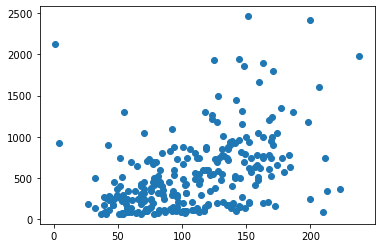

In [63]:
plt.scatter( df["Hits"], df["Salary"])

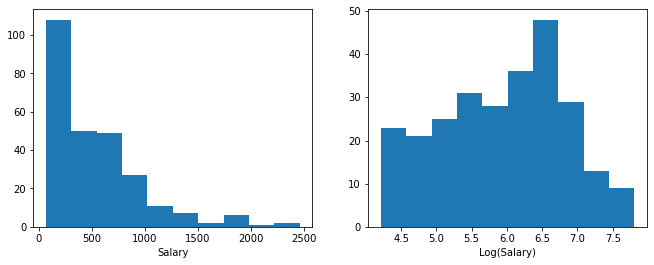

In [64]:
#X = df[["Years", "Hits"]].as_matrix()
X = df[["Years", "Hits"]].values
#y = np.log(df.Salary.as_matrix())
y = np.log(df.Salary.values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 4))

#ax1.hist(df.Salary.as_matrix())
ax1.hist(df.Salary.values)
ax1.set_xlabel("Salary")
ax2.hist(y)
ax2.set_xlabel("Log(Salary)")

plt.show()

In [65]:
regr = DecisionTreeRegressor(max_leaf_nodes = 5)
regr.fit(X, y)


DecisionTreeRegressor(max_leaf_nodes=5)

In [69]:
np.mean((regr.predict(X)-y)**2)

0.2687843540818694

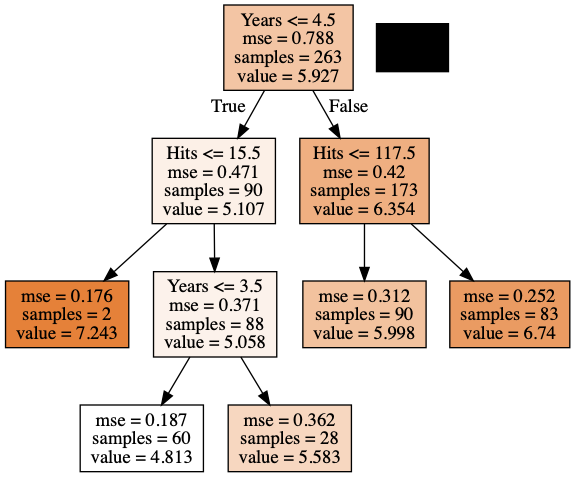

In [70]:
graph = print_tree(regr, features = ['Years', 'Hits'])
Image(graph.create_png()) # Make sure you have 'graphviz'. If not, use 'conda install graphviz' in shell. #


Text(11, 170, 'R3')

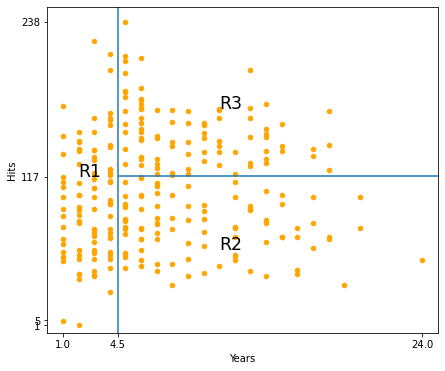

In [71]:
df.plot('Years', 'Hits', kind = 'scatter', color = 'orange', figsize = (7, 6))
plt.xlim(0, 25)
plt.ylim(ymin = -5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117,5, 238])
plt.vlines(4.5, ymin = -5, ymax = 250)
plt.hlines(117.5, xmin = 4.5, xmax = 25)
plt.annotate("R1", xy = (2, 117.5), fontsize = "xx-large")
plt.annotate("R2", xy = (11, 60), fontsize = "xx-large")
plt.annotate("R3", xy = (11, 170), fontsize = "xx-large")


Overall, the tree stratifies or segments the players into three regions of predictor space: players who have played for four or fewer years, players who have played for five or more years and who made fewer than 118 hits last year, and players who have played for five or more years and who made at least 118 hits last year. These three regions can be written as R1 ={X | Years < 4.5}, R2 ={X | Years >= 4.5, Hits < 117.5}, and R3 ={X | Years >= 4.5, Hits >= 117.5}. The predicted value for a player is given by the mean response value for the players in the region. 

In keeping with the tree analogy, the regions R1, R2, and R3 are known as terminal nodes or leaves of the tree. Decision trees are typically drawn upside down, in the sense that the leaves are at the bottom of the tree. The points along the tree where the predictor space is split are referred to as internal nodes. In Figure 8.1, the two internal nodes are indicated by the text Years < 4.5 and Hits < 117.5. We refer to the segments of the trees that connect the nodes as branches.

In [12]:
# Pruning, Not supported in scikit-learn? #

## 8.1.2 Classification Trees

A classification tree is very similar to a regression tree, except that it is used to predict a qualitative response rather than a quantitative one. 

In contrast to regression trees, for a classification tree, we predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs. 

Here we use Heart data to grow a classification tree as an example. 

In [72]:
df2 = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis = 1).dropna()
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [15]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]


In [16]:
X2 = df2.drop('AHD', axis = 1)
y2 = pd.factorize(df2.AHD)[0]


In [77]:
y2

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [73]:
clf = DecisionTreeClassifier(max_depth = None, max_leaf_nodes = 6, max_features = 3)
clf.fit(X2, y2)


DecisionTreeClassifier(max_features=3, max_leaf_nodes=6)

In [74]:
clf.score(X2, y2)


0.8181818181818182

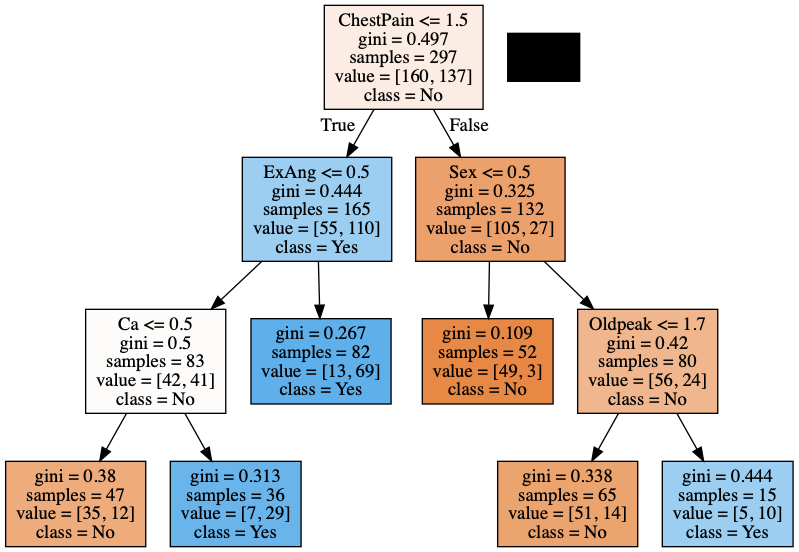

In [75]:
graph2 = print_tree(clf, features = X2.columns, class_names = ['No', 'Yes'])
Image(graph2.create_png()) 


# 8.3 Lab: Decision Trees

## 8.3.1 Fitting Classification Trees

We first use classification trees to analyze the Carseats data set. 

In [20]:
df3 = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis = 1)
df3.head()


   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  

Sales is a continuous variable. We begin by recoding it as a binary variable. We create a variable, called High, which takes on a value of 1 if the Sales variable exceeds 8, and takes on a value of 0 otherwise.

Similarly, we use 'map' function to convert 'Yes' and 'No' for variables 'US' and 'Urban' to 1/0. 

In [21]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()
df3.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


   Sales  CompPrice  Income  Advertising  Population  Price  ShelveLoc  Age  \
0   9.50        138      73           11         276    120          0   42   
1  11.22        111      48           16         260     83          1   65   
2  10.06        113      35           10         269     80          2   59   
3   7.40        117     100            4         466     97          2   55   
4   4.15        141      64            3         340    128          0   38   

   Education  Urban  US  High  
0         17      1   1     1  
1         10      1   1     1  
2         12      1   1     1  
3         14      1   1     0  
4         13      1   0     0  

In [22]:
X = df3.drop(['High', 'Sales'], axis = 1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.5, random_state = 0)


In [23]:
clf = DecisionTreeClassifier(max_depth = 6)
clf.fit(X, y)


DecisionTreeClassifier(max_depth=6)

Here we specify that the maximum depth of classification tree is 6. And according to the tree plot below, the attributes used to build the tree are "Price", "ShelveLoc", "Income", "CompPrice", "Population", "Advertising", "Age" and "US". 

In [24]:
print(classification_report(y, clf.predict(X)))


              precision    recall  f1-score   support

           0       0.89      0.99      0.93       236
           1       0.98      0.82      0.89       164

    accuracy                           0.92       400
   macro avg       0.93      0.90      0.91       400
weighted avg       0.92      0.92      0.92       400



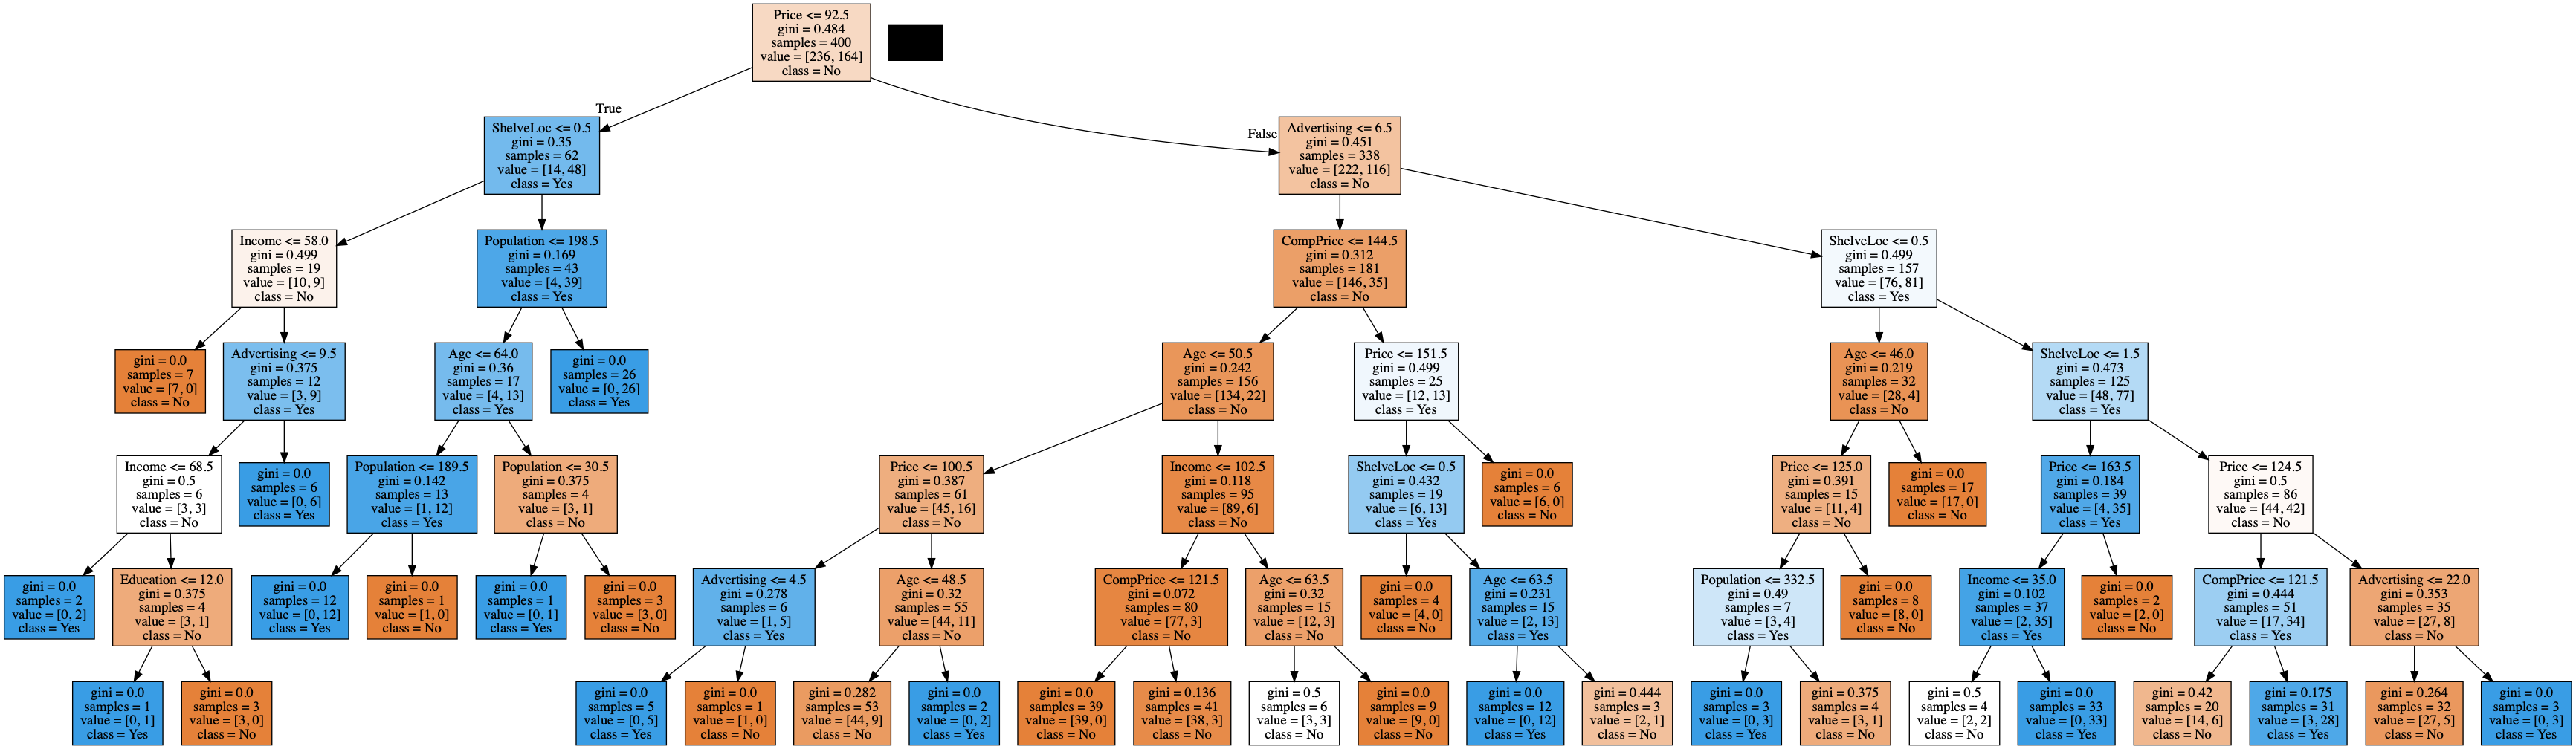

In [25]:
graph3 = print_tree(clf, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png()) 


In [26]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)


In [27]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm


True       No  Yes
Predicted         
No         99   32
Yes        19   50

In [28]:
cm = pd.DataFrame(confusion_matrix(y_test, pred, labels=[1,0]).T, index=['Yes', 'No'], columns=['True', 'False'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm


True       True  False
Predicted             
Yes          50     19
No           32     99

In [29]:
print(classification_report(y_test, pred))
# Pruning not supported in Scikit-learn? #

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       118
           1       0.72      0.61      0.66        82

    accuracy                           0.74       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.74      0.74      0.74       200



## 8.3.2 Fitting Regression Trees

In [32]:
boston_df = pd.read_csv('Data/Boston.csv').drop('Unnamed: 0', axis = 1)
boston_df.head()


      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  

In [33]:
X = boston_df.drop('medv', axis = 1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.5, random_state = 0)


In [34]:
regr2 = DecisionTreeRegressor(max_depth = 3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)


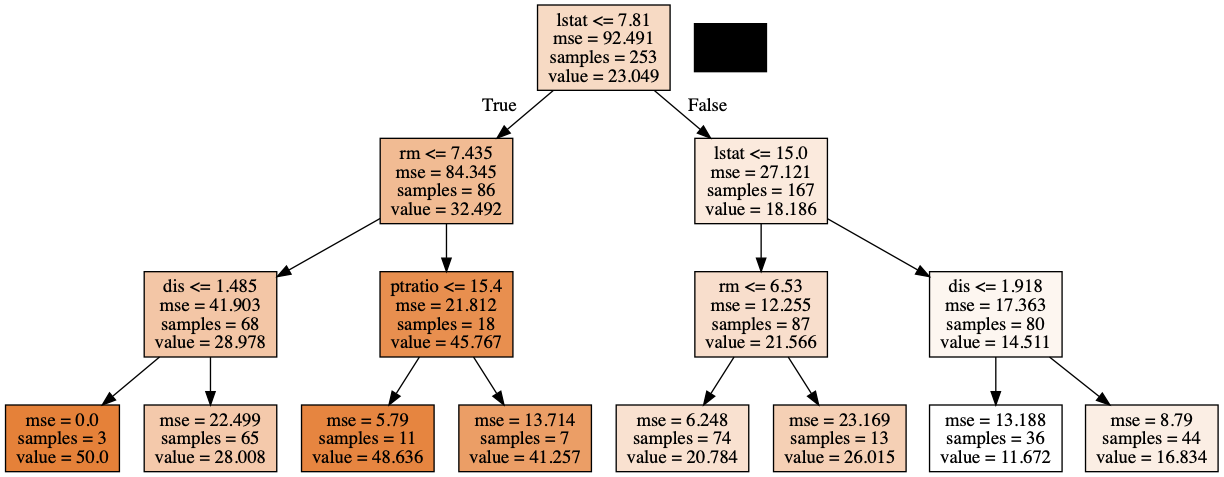

In [35]:
graph = print_tree(regr2, features = X.columns)
Image(graph.create_png())


Text(0, 0.5, 'y_test')

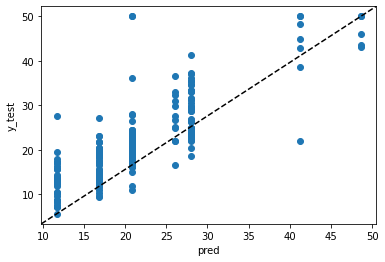

In [36]:
plt.scatter(pred, y_test, label = 'medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')


In [37]:
mean_squared_error(y_test, pred)


26.02323085009744

In other words, the test set MSE associated with the regression tree is 26.02. The square root of the MSE is therefore around 5.10, indicating that this model leads to test predictions that are within around $5,100 of the true median home value for the suburb.

## 8.3.3 Bagging and Random Forests

In [38]:
# import random #
# random.seed(3) # use either these two commands or specify "random_state" in RandomForestRegressor. 
X.shape

(506, 13)

In [39]:
# Bagging: using all features. # (Random Forest uses Subtrees.) #
regr1 = RandomForestRegressor(n_estimators = 500, max_features = 13, random_state = 1)
regr1.fit(X_train, y_train)
pred = regr1.predict(X_test)


The argument max_features = 13 indicates that all 13 predictors should be considered for each split of the tree—in other words, that bagging should be done. The argument n_estimators = 500 indicate that 500 trees are generated. 

In [40]:
mean_squared_error(y_test, pred)


15.971790639209502

The MSE here is much smaller than as indicated by one single Decision Tree. Bagging(and Random Forest) is more stable and accurate in term of prediction. 

Text(0, 0.5, 'y_test')

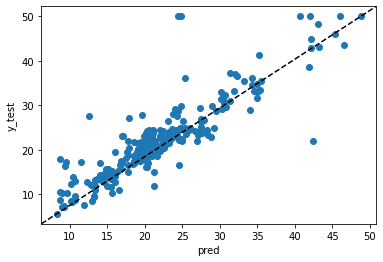

In [41]:
plt.scatter(pred, y_test, label = 'medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')


In [42]:
# Random forests: using 6 features. # Only use Subtrees. #
regr2 = RandomForestRegressor(n_estimators = 25, max_features=6, random_state=1)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)


14.668983652173912

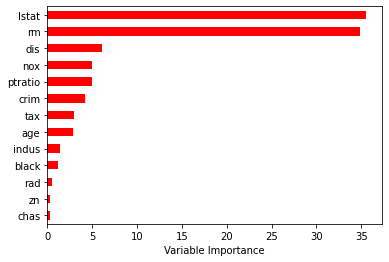

In [43]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None


## 8.3.4 Boosting 

learning_rate = 0.001 is the Shrinkage Parameter. loss = 'ls' specifies the loss function to be optimized. http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


We use the default setting(lm) for loss here since we are projecting a regression with Gaussian distribution. 

In [44]:
regr = GradientBoostingRegressor(n_estimators=5000, loss = 'ls', learning_rate=0.001, random_state=1)
regr.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=1)

zn          0.019173
chas        0.118158
rad         0.191885
black       0.456681
indus       0.462013
nox         0.828558
age         0.921815
tax         1.031098
crim        2.875549
ptratio     4.478590
dis         6.015605
rm         27.812236
lstat      54.788641
dtype: float64


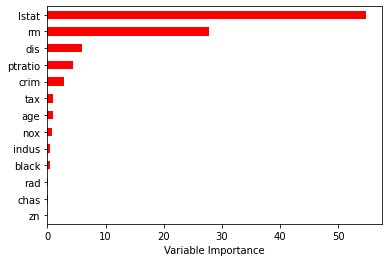

In [45]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None


We see that lstat and rm are by far the most important variables. 

In [46]:
mean_squared_error(y_test, regr.predict(X_test))


15.738489429387327

Now we take Lambda(learning rate) = 0.2 and see how the result varies. 

In [47]:
regr = GradientBoostingRegressor(n_estimators=5000, loss = 'ls', learning_rate=0.2, random_state=1)
regr.fit(X_train, y_train)
mean_squared_error(y_test, regr.predict(X_test))


15.53011181594126

It turns out the result is quite alike. 